In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sys
import os

# Add 'src' to path so we can import our modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.config import DATA_PROCESSED, DATA_RAW
from src.ml_engine import generate_historical_traffic_data

# Set visual style
sns.set_theme(style="whitegrid")
%matplotlib inline

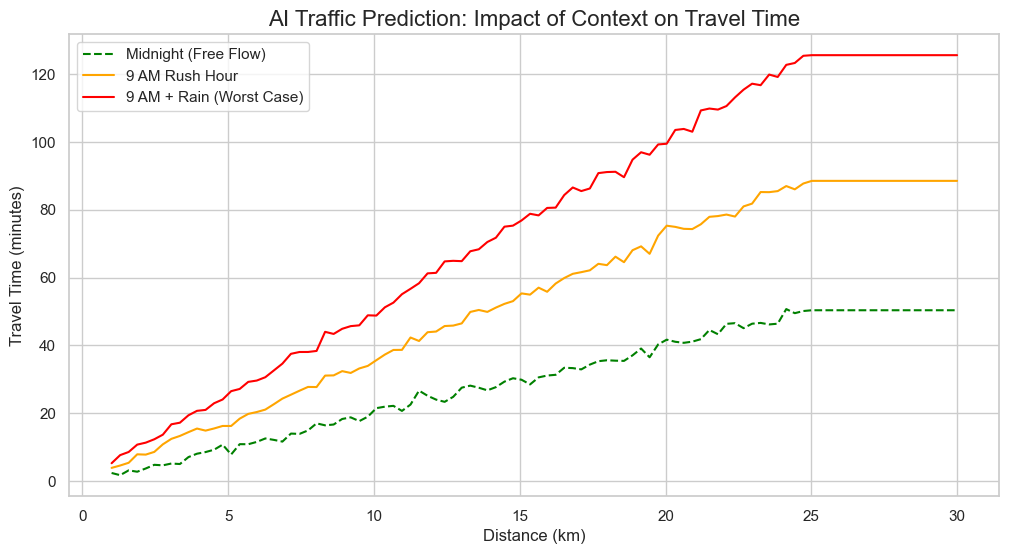

In [5]:
# 1. Load the trained model
model = xgb.XGBRegressor()
model_path = os.path.join(DATA_PROCESSED, 'traffic_model.json')
model.load_model(model_path)

# 2. Create dummy data for testing (0 to 30 km trips)
distances = np.linspace(1, 30, 100)

# Scenario A: Midnight (No Traffic, Hour = 2 AM)
df_midnight = pd.DataFrame({
    'distance_km': distances,
    'hour': 2,
    'weather_rain': 0
})

# Scenario B: Rush Hour (Heavy Traffic, Hour = 9 AM)
df_rush = pd.DataFrame({
    'distance_km': distances,
    'hour': 9,
    'weather_rain': 0
})

# Scenario C: Rush Hour + Rain
df_rain = pd.DataFrame({
    'distance_km': distances,
    'hour': 9,
    'weather_rain': 1
})

# 3. Predict
time_midnight = model.predict(df_midnight)
time_rush = model.predict(df_rush)
time_rain = model.predict(df_rain)

# 4. Plot
plt.figure(figsize=(12, 6))
plt.plot(distances, time_midnight, label='Midnight (Free Flow)', color='green', linestyle='--')
plt.plot(distances, time_rush, label='9 AM Rush Hour', color='orange')
plt.plot(distances, time_rain, label='9 AM + Rain (Worst Case)', color='red')

plt.title("AI Traffic Prediction: Impact of Context on Travel Time", fontsize=16)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Travel Time (minutes)", fontsize=12)
plt.legend()
plt.show()

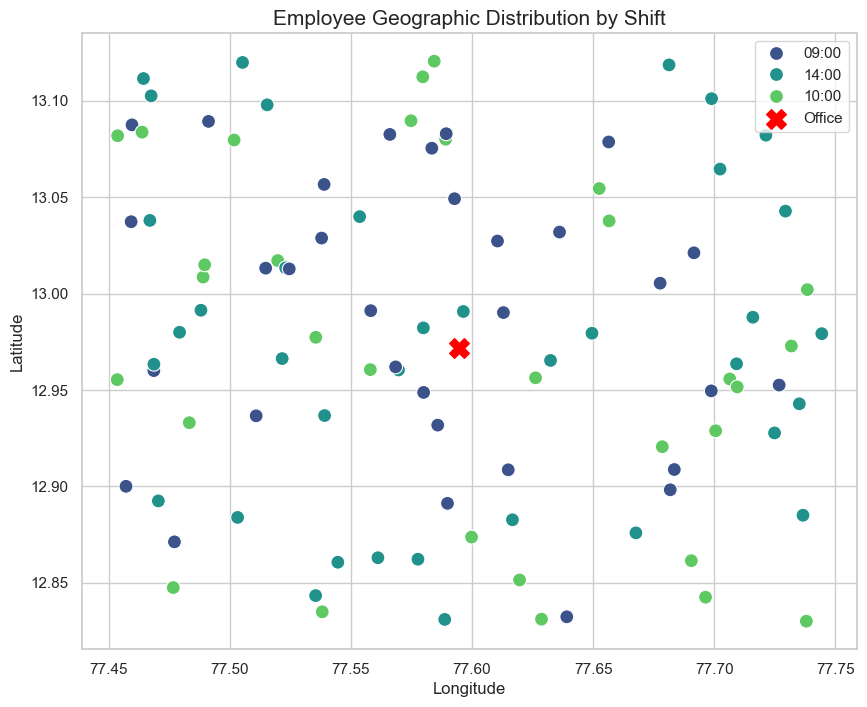

In [6]:
# Load Employee Data
df = pd.read_csv(os.path.join(DATA_RAW, 'employees.csv'))

# Filter out the office (Depot)
df_emp = df[df['emp_id'] != 'OFFICE_DEPOT']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', data=df_emp, hue='shift_start', s=100, palette='viridis')
plt.title("Employee Geographic Distribution by Shift", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Mark the Office
plt.scatter(77.5946, 12.9716, color='red', marker='X', s=200, label='Office')
plt.legend()
plt.show()

Generating synthetic traffic history...


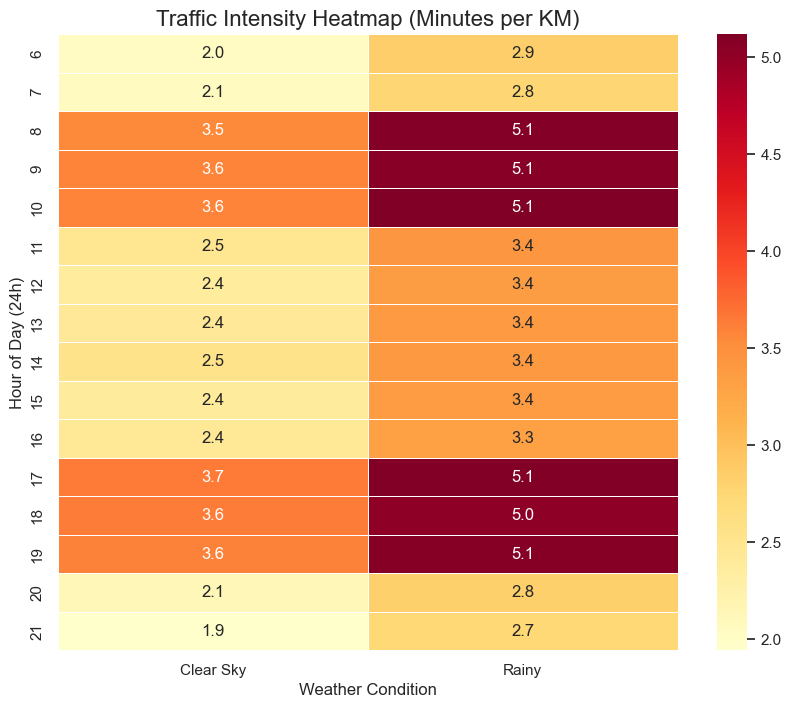

In [7]:
# Generate a larger dataset for better visualization
df_viz = generate_historical_traffic_data(n_samples=2000)

# Create a Pivot Table: Average Duration by Hour and Weather
# We normalize by distance to get "Minutes per km" (Pace)
df_viz['pace_min_per_km'] = df_viz['duration_min'] / df_viz['distance_km']
heatmap_data = df_viz.pivot_table(
    index='hour', 
    columns='weather_rain', 
    values='pace_min_per_km', 
    aggfunc='mean'
)

# Rename columns for clarity
heatmap_data.columns = ['Clear Sky', 'Rainy']

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", fmt=".1f", linewidths=.5)

plt.title("Traffic Intensity Heatmap (Minutes per KM)", fontsize=16)
plt.ylabel("Hour of Day (24h)", fontsize=12)
plt.xlabel("Weather Condition", fontsize=12)
plt.show()

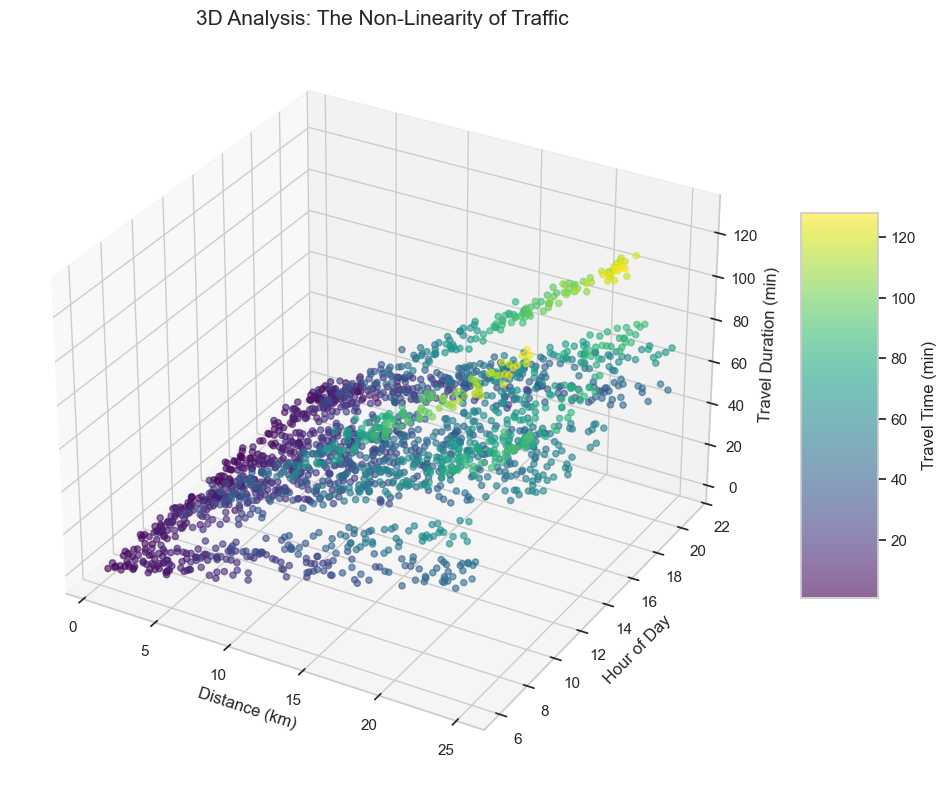

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter Plot
# X = Distance, Y = Hour of Day, Z = Duration (Actual Time)
img = ax.scatter(
    df_viz['distance_km'], 
    df_viz['hour'], 
    df_viz['duration_min'], 
    c=df_viz['duration_min'], 
    cmap='viridis', 
    alpha=0.6,
    s=20
)

ax.set_xlabel('Distance (km)')
ax.set_ylabel('Hour of Day')
ax.set_zlabel('Travel Duration (min)')
ax.set_title('3D Analysis: The Non-Linearity of Traffic', fontsize=15)

# Add a color bar to show duration intensity
cbar = fig.colorbar(img, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Travel Time (min)')

plt.show()